In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
import itertools 
# import plotly.express as pltly
# import plotly
import pandas as pd
from functools import partial
import networkx as net
# from utils import TwoSectionH
# import plotly.graph_objects as go
# import plotly.graph_objects as go

In [2]:
np.set_printoptions(suppress = True)

arameters for $\mu-L$ convergence
* $\mu = 2\lambda$       regularization parameter

In [5]:
K = 20
# train_images=train_images.reshape((60000,784),order='C')
# SampleCov=[(train_images[sample_indices[i]].T @ train_images[sample_indices[i]]) / len(sample_indices[i]) for i in range(K)]
# lambdaSampleCov=[np.linalg.eigvalsh(SampleCov[i]).reshape((784,1)) for i in range(K)]
# E = 1./2*(np.eye(K) - np.ones((K,1)) @ np.ones((1,K)) / K)
# lambdaE=np.linalg.eigvalsh(E).reshape((K,1))
# lambda_base = [max(.5*lambdaSampleCov[i]).squeeze() for i in range(K)]
lamda = .002
# L = max(lambda_base) + lamda
L = .1581 + .002
mu = lamda
kappa = L / mu
gb = .1 # as the norm bound G for gradient
bar_sigma_sqr= 1.
a0 = 20 # initial distance between the average model parameter and the optimal one

*The parameters in the following block is applicable to the upper-bound for the digital scheme only.*

In [6]:
np.random.seed(2)

num_lack_max = 4
num_lack = np.random.randint(0,num_lack_max+1,(K,))
for k in range(K):
    arr = np.ones((10,))
    arr[:num_lack[k]] = 0
    np.random.shuffle(arr)
        
d_min = 50
d_max = 200
rho =  d_min + (d_max - d_min) * np.random.rand(K,1) 
theta = 2 * np.pi * np.random.rand(K,1)
# D = 125 * np.ones((K, K)) # mimic the effect of the same pathloss
D = np.sqrt(rho ** 2 + rho.T ** 2 - 2 * (rho @ rho.T) * np.cos(theta - theta.T))
# Fill in D[i,i] some non-zero value to avoid Inf in PL
for i in range(K):
    if i:
        D[i,i] = D[i,i-1]
    else:
        D[i,i] = D[i,i+1]
A0 = 10 ** (-3.35)
d0 = 1
gamma = 3.76
# PL = A0 * ((D / d0) ** (-gamma))
d = 7850
# N = 7943
# barP = 2e-6
# M = 10 # the chromatic number for the digital scheme
N0 = 10 ** (-169/10) * 1e-3

seeds = iter(range(1000))
prob = 0.5
alg_connect = 0
while alg_connect < 1e-4:
#     # Generate a star-based ER graph
#     ER = net.erdos_renyi_graph(K-1, 0.1, seed = next(seeds))
#     ER.add_node(K-1)
    G = net.star_graph(reversed(range(K)))
#     G.add_edges_from(ER.edges())

#     # Generate an arbitrary ER graph
#     G = net.erdos_renyi_graph(K, p, seed = next(seeds))

#     # Generate a chain (cycle) graph
#     G = net.cycle_graph(K)
#     G.remove_edge(0, K-1)
#     # Base an ER graph with prob on the chain graph to improve the spectral gap delta
#     ER = net.erdos_renyi_graph(K, prob, seed = next(seeds))
#     G.add_edges_from(ER.edges())

#     # Generate a 2-D torus (5-by-4)
#     G = net.grid_2d_graph(5, 4, periodic=True)
#     mapping = {(m,n):4*m+n for m, n in G.nodes()}
#     _ = net.relabel_nodes(G, mapping, copy=False)

#     # Generate a complete graph
#     G = net.complete_graph(K)

    LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
    E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
    alg_connect = E[1] 
    
c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)]
b = 64

funcG= lambda barP, M, N, n, i:np.exp(-( np.power(2, n*b*M / N) - 1 ) / (barP / N0) * c_array[i] / (M * A0) )
# omega = min( 1- funcG(barP, M, N, 1, i) + sum(funcG(barP, M, N, n, i) for n in range(1,d+1)) / d for i in range(K) )
p = lambda delta, beta, omega: delta**2 * omega / (2 * (16*delta + delta**2 + 4*beta**2 + 2*delta*beta**2 - 8*delta*omega))
zeta0 = lambda delta, beta, omega: delta * omega / (16*delta + delta**2 + 4*beta**2 + 2*delta*beta**2 - 8*delta*omega)

**Evaluate the analytical upper-bound (*relative*) for $F(\tilde{\theta}_T) - F^\ast$ vs SNR at $T=2000$**

40000000.0 | 3119881.725238714


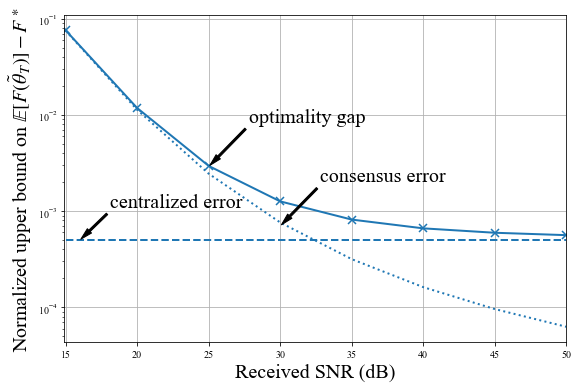

In [8]:
gb = 1
a = 4.0e7
# M = 8 # the chromatic number for the digital scheme
N = 10000
# opt = 0.41

T0 = 0
T1 = 2e3
T_array = np.arange(T1)
sT = np.cumsum((a+T_array)**2)
sT0 = sT[0] # the initial iteration used to evaluate the upper bounds for normalization
sT1 = sT[-1]
plt.rc('font', family='Times New Roman')
mpl.rcParams["mathtext.fontset"] = 'stix'
fig, ax = plt.subplots(figsize = (9.0,6.0))

# Generate a 2-D torus (5-by-4)
G = net.grid_2d_graph(5, 4, periodic=True)
mapping = {(m,n):4*m+n for m, n in G.nodes()}
_ = net.relabel_nodes(G, mapping, copy=False)
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
delta = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta = np.linalg.norm(np.eye(K) - W, ord=2)

c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)]
M = 8 # the chromatic number for 2-D torus
# # ideal communication with the estimation quality omega = 1
# omega = 1
# og = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
# 1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
# (158.45 * 24 * L * T_array) / (mu**2 * p(delta,beta,omega) **2 * sT) * gb**2
# plt.semilogy(T_array, og, ls = '--', marker = 'x', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'ideal commun.')


barP_array = np.logspace(-8.2, -4.7, num = 8)
og1_array = np.ones(barP_array.shape)
og1_ini_array = np.ones(barP_array.shape)
og1_partI = mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K)
og1_partI_array = og1_partI * np.ones(barP_array.shape)
og1_partII_array= np.ones(barP_array.shape)
for n, barP in zip(range(len(barP_array)), barP_array):
    omega = min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) )
    if not n:
        print(f'{a} | {max(5/p(delta,beta,omega), 13 * L/mu)}')
    og1_array[n] = mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
    1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K) + \
    (158.45 * 24 * L * T1) / (mu**2 * p(delta,beta,omega) **2 * sT1) * gb**2
#     plt.semilogy(T_array, og1/og1[0], color = 'orangered', marker = 'o', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'sum term (SNR $40$dB)')

    og1_partII_array[n] = (158.45 * 24 * L * T1) / (mu**2 * p(delta,beta,omega) **2 * sT1) * gb**2
    # plt.semilogy(T_array, og2_partII/og2[0], ls = ':', color = 'C0', label = r'$\mathcal{O}\left(\frac{LG^2}{\mu^2(p(\delta,\omega))^2T^2}\right)$')
#     plt.semilogy(T_array, og1_partII/og1[0], ls = ':', color = 'orangered')

    og1_ini_array[n] = mu/3.25 * (a**3 - 3.25 * a **2) / sT0 * a0 + \
    1.625 * T0 * (T0 + 2 * a ) / (mu * sT0) * (bar_sigma_sqr / K) + \
    (158.45 * 24 * L * T0) / (mu**2 * p(delta,beta,omega) **2 * sT0) * gb**2
   
plt.semilogy(15 + 10*np.log10(barP_array/barP_array[0]), og1_array/og1_ini_array, lw = 2.0, color = 'C0', marker = 'x', fillstyle = 'none', ms = 8, mew = 1.5, label = r'sum term')
plt.semilogy(15 + 10*np.log10(barP_array/barP_array[0]), og1_partI_array/og1_ini_array, lw = 2.0, ls = '--', color = 'C0', label = r'centralized term')
plt.semilogy(15 + 10*np.log10(barP_array/barP_array[0]), og1_partII_array/og1_ini_array, lw = 2.0, ls = ':', color = 'C0', label = r'consensus-error induced term')

plt.xlabel(r'Received SNR (dB)', fontsize = 20)
plt.ylabel(r'Normalized upper bound on $\mathbb{E}[F(\tilde{\theta}_T)]-F^\ast$', fontsize = 20)
# plt.title(r'$\lambda_2(L) = 8$')
plt.xlim((14.9, 50))
# plt.ylim((0, 0.02))
plt.grid()

# # Place legend for individual curves
# plt.legend(loc = 'upper right', fontsize = 14)
# Place marks using annotation
_ = ax.annotate(r'optimality gap',
            xy = (25, 0.0029), xycoords = 'data',
            xytext = (40, 45), textcoords = 'offset points', fontsize = 20,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'consensus error',
            xy = (30, 0.0007), xycoords = 'data',
            xytext = (40, 45), textcoords = 'offset points', fontsize = 20,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'centralized error',
            xy = (16, 0.0005), xycoords = 'data',
            xytext = (30, 33), textcoords = 'offset points', fontsize = 20,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))

# plt.savefig('C:/Users/Helen/Documents/visiting_research@KCL/D2D_DSGD/XXX20-FL_over_D2D/eps/dig_ub_og_vs_SNR_small_T.eps',format='eps', dpi=600)
plt.show()      

In [62]:
(og1_partII_array/og1_ini_array)[3]

0.0007625324092409896

**Evaluate the analytical upper-bound (*relative*) for $F(\tilde{\theta}_T) - F^\ast$ vs SNR at $T=5000$**

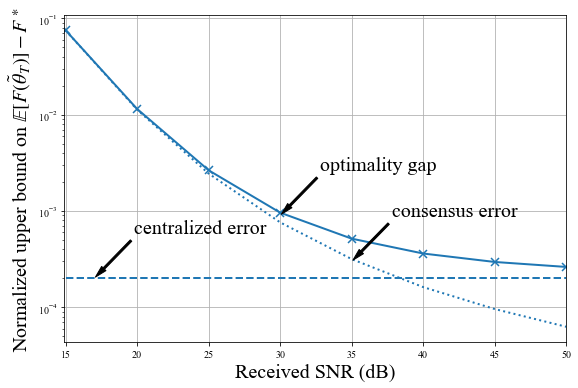

In [10]:
gb = 1
a = 4.0e7
# M = 8 # the chromatic number for the digital scheme
N = 10000
# opt = 0.41

T0 = 0 # the initial iteration used to evaluate the upper bounds for normalization
T1 = 5e3
T_array = np.arange(T1)
sT = np.cumsum((a+T_array)**2)
sT0 = sT[0]
sT1 = sT[-1]
plt.rc('font', family='Times New Roman')
mpl.rcParams["mathtext.fontset"] = 'stix'
fig, ax = plt.subplots(figsize = (9.0,6.0))

# Generate a 2-D torus (5-by-4)
G = net.grid_2d_graph(5, 4, periodic=True)
mapping = {(m,n):4*m+n for m, n in G.nodes()}
_ = net.relabel_nodes(G, mapping, copy=False)
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
delta = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta = np.linalg.norm(np.eye(K) - W, ord=2)

c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)]
M = 8 # the chromatic number for 2-D torus
# # ideal communication with the estimation quality omega = 1
# omega = 1
# og = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
# 1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
# (158.45 * 24 * L * T_array) / (mu**2 * p(delta,beta,omega) **2 * sT) * gb**2
# plt.semilogy(T_array, og, ls = '--', marker = 'x', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'ideal commun.')


barP_array = np.logspace(-8.2, -4.7, num = 8)
og1_array = np.ones(barP_array.shape)
og1_ini_array = np.ones(barP_array.shape)
og1_partI = mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K)
og1_partI_array = og1_partI * np.ones(barP_array.shape)
og1_partII_array= np.ones(barP_array.shape)
for n, barP in zip(range(len(barP_array)), barP_array):
    omega = min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) )
    og1_array[n] = mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
    1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K) + \
    (158.45 * 24 * L * T1) / (mu**2 * p(delta,beta,omega) **2 * sT1) * gb**2
#     plt.semilogy(T_array, og1/og1[0], color = 'orangered', marker = 'o', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'sum term (SNR $40$dB)')

    og1_partII_array[n] = (158.45 * 24 * L * T1) / (mu**2 * p(delta,beta,omega) **2 * sT1) * gb**2
    # plt.semilogy(T_array, og2_partII/og2[0], ls = ':', color = 'C0', label = r'$\mathcal{O}\left(\frac{LG^2}{\mu^2(p(\delta,\omega))^2T^2}\right)$')
#     plt.semilogy(T_array, og1_partII/og1[0], ls = ':', color = 'orangered')

    og1_ini_array[n] = mu/3.25 * (a**3 - 3.25 * a **2) / sT0 * a0 + \
    1.625 * T0 * (T0 + 2 * a ) / (mu * sT0) * (bar_sigma_sqr / K) + \
    (158.45 * 24 * L * T0) / (mu**2 * p(delta,beta,omega) **2 * sT0) * gb**2
   
plt.semilogy(15 + 10*np.log10(barP_array/barP_array[0]), og1_array/og1_ini_array, lw = 2.0, color = 'C0', marker = 'x', fillstyle = 'none', ms = 8, mew = 1.5, label = r'sum term')
plt.semilogy(15 + 10*np.log10(barP_array/barP_array[0]), og1_partI_array/og1_ini_array, lw = 2.0, ls = '--', color = 'C0', label = r'centralized term')
plt.semilogy(15 + 10*np.log10(barP_array/barP_array[0]), og1_partII_array/og1_ini_array, lw = 2.0, ls = ':', color = 'C0', label = r'consensus-error induced term')

plt.xlabel(r'Received SNR (dB)', fontsize = 20)
plt.ylabel(r'Normalized upper bound on $\mathbb{E}[F(\tilde{\theta}_T)]-F^\ast$', fontsize = 20)
# plt.title(r'$\lambda_2(L) = 8$')
plt.xlim((14.9, 50))
# plt.ylim((0, 0.02))
plt.grid()

# # Place legend for individual curves
# plt.legend(loc = 'upper right', fontsize = 14)
# Place marks using annotation
_ = ax.annotate(r'optimality gap',
            xy = (30, 0.0009), xycoords = 'data',
            xytext = (40, 45), textcoords = 'offset points', fontsize = 20,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'consensus error',
            xy = (35, 0.0003), xycoords = 'data',
            xytext = (40, 45), textcoords = 'offset points', fontsize = 20,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'centralized error',
            xy = (17, 0.0002), xycoords = 'data',
            xytext = (40, 45), textcoords = 'offset points', fontsize = 20,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))

# plt.savefig('C:/Users/Helen/Documents/visiting_research@KCL/D2D_DSGD/XXX20-FL_over_D2D/eps/dig_ub_og_vs_SNR_large_T.eps',format='eps', dpi=600)
plt.show()  

In [70]:
(og1_partII_array/og1_ini_array)[3]

0.0007624752231220631

In [5]:
D = 125 * np.ones((K, K)) # mimic the effect of the same pathloss

**Evaluate the analytical upper-bound (*relative*) for $F(\tilde{\theta}_T) - F^\ast$ for varying topologies at $T=2000$**

130000000.0 | 39869.49787771601
130000000.0 | 243187.19859429664
130000000.0 | 1991440.0055511463
130000000.0 | 3204135.348371903


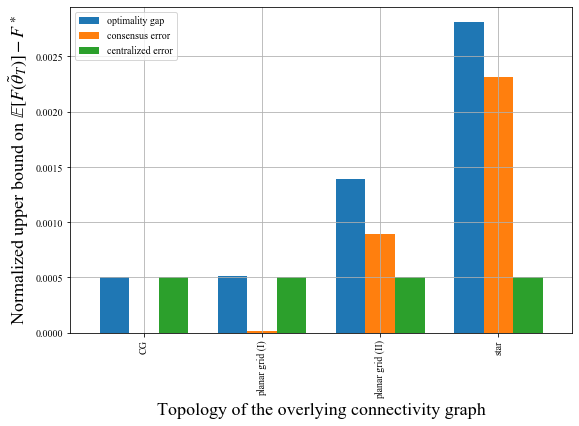

In [6]:
gb = 1
a = 1.3e8
barP = 2e-7
M = K
N = 10000
# opt = 0.41

T0 = 0
T1 = 2e3
T_array = np.arange(T1)
sT = np.cumsum((a+T_array)**2)
sT0 = sT[0] # the initial iteration used to evaluate the upper bounds for normalization
sT1 = sT[-1]
plt.rc('font', family='Times New Roman')
mpl.rcParams["mathtext.fontset"] = 'stix'
fig, ax = plt.subplots(figsize = (9.0,6.0))

og1_list = [] # store the optimality gap
og1_ini_list = [] # sotre the initial optimality gap
og1_partI = mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K)
og1_partI_list = [] # store the centralized error
og1_partII_list = [] # store the consensus error

# Generate a complete graph
G = net.complete_graph(K)
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
delta1 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta1 = np.linalg.norm(np.eye(K) - W, ord=2)

c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)]
omega1 = min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) )
print(f'{a} | {max(5/p(delta1,beta1,omega1), 13 * L/mu)}')

og1_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T1) / (mu**2 * p(delta1,beta1,omega1) **2 * sT1) * gb**2 )

og1_partI_list.append( og1_partI )

og1_partII_list.append( (158.45 * 24 * L * T1) / (mu**2 * p(delta1,beta1,omega1) **2 * sT1) * gb**2 )

og1_ini_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT0 * a0 + \
1.625 * T0 * (T0 + 2 * a ) / (mu * sT0) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T0) / (mu**2 * p(delta1,beta1,omega1) **2 * sT0) * gb**2 )


# Generate a 2-D torus (5-by-4, periodic)
G = net.grid_2d_graph(5, 4, periodic=True)
mapping = {(m,n):4*m+n for m, n in G.nodes()}
_ = net.relabel_nodes(G, mapping, copy=False)
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
delta2 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta2 = np.linalg.norm(np.eye(K) - W, ord=2)

c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)]
omega2 = min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) )
print(f'{a} | {max(5/p(delta2,beta2,omega2), 13 * L/mu)}')

og1_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T1) / (mu**2 * p(delta2,beta2,omega2) **2 * sT1) * gb**2 )

og1_partI_list.append( og1_partI )

og1_partII_list.append( (158.45 * 24 * L * T1) / (mu**2 * p(delta2,beta2,omega2) **2 * sT1) * gb**2 )

og1_ini_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT0 * a0 + \
1.625 * T0 * (T0 + 2 * a ) / (mu * sT0) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T0) / (mu**2 * p(delta2,beta2,omega2) **2 * sT0) * gb**2 )


# Generate a 2-D torus (5-by-4, aperiodic)
G = net.grid_2d_graph(5, 4, periodic=False)
mapping = {(m,n):4*m+n for m, n in G.nodes()}
_ = net.relabel_nodes(G, mapping, copy=False)
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
delta3 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta3 = np.linalg.norm(np.eye(K) - W, ord=2)

c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)]
omega3 = min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) )
print(f'{a} | {max(5/p(delta3,beta3,omega3), 13 * L/mu)}')

og1_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T1) / (mu**2 * p(delta3,beta3,omega3) **2 * sT1) * gb**2 )

og1_partI_list.append( og1_partI )

og1_partII_list.append( (158.45 * 24 * L * T1) / (mu**2 * p(delta3,beta3,omega3) **2 * sT1) * gb**2 )

og1_ini_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT0 * a0 + \
1.625 * T0 * (T0 + 2 * a ) / (mu * sT0) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T0) / (mu**2 * p(delta3,beta3,omega3) **2 * sT0) * gb**2 )


# Generate a star graph
G = net.star_graph(reversed(range(K)))
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
delta4 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta4 = np.linalg.norm(np.eye(K) - W, ord=2)

c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)]
omega4 = min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) )
print(f'{a} | {max(5/p(delta4,beta4,omega4), 13 * L/mu)}')

og1_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T1) / (mu**2 * p(delta4,beta4,omega4) **2 * sT1) * gb**2 )

og1_partI_list.append( og1_partI )

og1_partII_list.append( (158.45 * 24 * L * T1) / (mu**2 * p(delta4,beta4,omega4) **2 * sT1) * gb**2 )

og1_ini_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT0 * a0 + \
1.625 * T0 * (T0 + 2 * a ) / (mu * sT0) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T0) / (mu**2 * p(delta4,beta4,omega4) **2 * sT0) * gb**2 )


# # Generate a chain (cycle) graph
# G = net.cycle_graph(K)
# LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
# E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
# alg_connect = E[1] 
# alpha = 2 / (E[K-1] + E[1])
# W = np.eye(K) - alpha * LP
# delta5 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
# beta5 = np.linalg.norm(np.eye(K) - W, ord=2)

# c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)]
# omega5 = min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) )
# print(f'{a} | {max(5/p(delta5,beta5,omega5), 13 * L/mu)}')

# og1_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
# 1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K) + \
# (158.45 * 24 * L * T1) / (mu**2 * p(delta5,beta5,omega5) **2 * sT1) * gb**2 )

# og1_partI_list.append( og1_partI )

# og1_partII_list.append( (158.45 * 24 * L * T1) / (mu**2 * p(delta5,beta5,omega5) **2 * sT1) * gb**2 )

# og1_ini_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT0 * a0 + \
# 1.625 * T0 * (T0 + 2 * a ) / (mu * sT0) * (bar_sigma_sqr / K) + \
# (158.45 * 24 * L * T0) / (mu**2 * p(delta5,beta5,omega5) **2 * sT0) * gb**2 )

df1 = pd.DataFrame(columns = ['optimality gap', 'consensus error', 'centralized error'], 
                   index = ['CG', 'planar grid (I)', 'planar grid (II)', 'star'])
df1['optimality gap'] = np.array(og1_list) / np.array(og1_ini_list)
df1['consensus error'] = np.array(og1_partII_list) /np.array(og1_ini_list)
df1['centralized error'] = np.array(og1_partI_list) / np.array(og1_ini_list)
df1.plot.bar(width=0.75, ax = ax)

plt.xlabel(r'Topology of the overlying connectivity graph', fontsize = 18)
plt.ylabel(r'Normalized upper bound on $\mathbb{E}[F(\tilde{\theta}_T)]-F^\ast$', fontsize = 18)
# plt.title(r'$\lambda_2(L) = 8$')
# plt.xlim((0, 5000))
# plt.ylim((0, 1))
plt.grid()

# # Place legend for individual curves
# plt.legend(loc = 'upper right', fontsize = 14)

# plt.savefig('C:/Users/Helen/Documents/visiting_research@KCL/D2D_DSGD/XXX20-FL_over_D2D/eps/dig_ub_og_vs_topology_small_T.eps',format='eps', dpi=600)
plt.show()

In [9]:
delta4

0.09523809523809479

**Evaluate the analytical upper-bound (*relative*) for $F(\tilde{\theta}_T) - F^\ast$ for varying topologies at $T=5000$**

130000000.0 | 39869.49787771601
130000000.0 | 243187.19859429664
130000000.0 | 1991440.0055511463
130000000.0 | 3204135.348371903


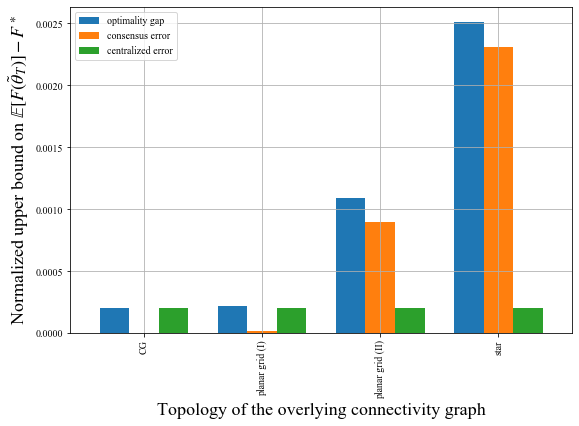

In [14]:
gb = 1
a = 1.3e8
barP = 2e-7
M = K
N = 10000
# opt = 0.41

T0 = 0
T1 = 5e3
T_array = np.arange(T1)
sT = np.cumsum((a+T_array)**2)
sT0 = sT[0] # the initial iteration used to evaluate the upper bounds for normalization
sT1 = sT[-1]
plt.rc('font', family='Times New Roman')
mpl.rcParams["mathtext.fontset"] = 'stix'
fig, ax = plt.subplots(figsize = (9.0,6.0))

og1_list = [] # store the optimality gap
og1_ini_list = [] # sotre the initial optimality gap
og1_partI = mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K)
og1_partI_list = [] # store the centralized error
og1_partII_list = [] # store the consensus error

# Generate a complete graph
G = net.complete_graph(K)
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
delta1 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta1 = np.linalg.norm(np.eye(K) - W, ord=2)

c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)]
omega1 = min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) )
print(f'{a} | {max(5/p(delta1,beta1,omega1), 13 * L/mu)}')

og1_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T1) / (mu**2 * p(delta1,beta1,omega1) **2 * sT1) * gb**2 )

og1_partI_list.append( og1_partI )

og1_partII_list.append( (158.45 * 24 * L * T1) / (mu**2 * p(delta1,beta1,omega1) **2 * sT1) * gb**2 )

og1_ini_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT0 * a0 + \
1.625 * T0 * (T0 + 2 * a ) / (mu * sT0) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T0) / (mu**2 * p(delta1,beta1,omega1) **2 * sT0) * gb**2 )


# Generate a 2-D torus (5-by-4, periodic)
G = net.grid_2d_graph(5, 4, periodic=True)
mapping = {(m,n):4*m+n for m, n in G.nodes()}
_ = net.relabel_nodes(G, mapping, copy=False)
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
delta2 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta2 = np.linalg.norm(np.eye(K) - W, ord=2)

c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)]
omega2 = min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) )
print(f'{a} | {max(5/p(delta2,beta2,omega2), 13 * L/mu)}')

og1_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T1) / (mu**2 * p(delta2,beta2,omega2) **2 * sT1) * gb**2 )

og1_partI_list.append( og1_partI )

og1_partII_list.append( (158.45 * 24 * L * T1) / (mu**2 * p(delta2,beta2,omega2) **2 * sT1) * gb**2 )

og1_ini_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT0 * a0 + \
1.625 * T0 * (T0 + 2 * a ) / (mu * sT0) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T0) / (mu**2 * p(delta2,beta2,omega2) **2 * sT0) * gb**2 )


# Generate a 2-D torus (5-by-4, aperiodic)
G = net.grid_2d_graph(5, 4, periodic=False)
mapping = {(m,n):4*m+n for m, n in G.nodes()}
_ = net.relabel_nodes(G, mapping, copy=False)
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
delta3 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta3 = np.linalg.norm(np.eye(K) - W, ord=2)

c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)]
omega3 = min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) )
print(f'{a} | {max(5/p(delta3,beta3,omega3), 13 * L/mu)}')

og1_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T1) / (mu**2 * p(delta3,beta3,omega3) **2 * sT1) * gb**2 )

og1_partI_list.append( og1_partI )

og1_partII_list.append( (158.45 * 24 * L * T1) / (mu**2 * p(delta3,beta3,omega3) **2 * sT1) * gb**2 )

og1_ini_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT0 * a0 + \
1.625 * T0 * (T0 + 2 * a ) / (mu * sT0) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T0) / (mu**2 * p(delta3,beta3,omega3) **2 * sT0) * gb**2 )


# Generate a star graph
G = net.star_graph(reversed(range(K)))
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
delta4 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta4 = np.linalg.norm(np.eye(K) - W, ord=2)

c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)]
omega4 = min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) )
print(f'{a} | {max(5/p(delta4,beta4,omega4), 13 * L/mu)}')

og1_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T1) / (mu**2 * p(delta4,beta4,omega4) **2 * sT1) * gb**2 )

og1_partI_list.append( og1_partI )

og1_partII_list.append( (158.45 * 24 * L * T1) / (mu**2 * p(delta4,beta4,omega4) **2 * sT1) * gb**2 )

og1_ini_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT0 * a0 + \
1.625 * T0 * (T0 + 2 * a ) / (mu * sT0) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T0) / (mu**2 * p(delta4,beta4,omega4) **2 * sT0) * gb**2 )


# # Generate a chain (cycle) graph
# G = net.cycle_graph(K)
# LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
# E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
# alg_connect = E[1] 
# alpha = 2 / (E[K-1] + E[1])
# W = np.eye(K) - alpha * LP
# delta5 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
# beta5 = np.linalg.norm(np.eye(K) - W, ord=2)

# c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)]
# omega5 = min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) )
# print(f'{a} | {max(5/p(delta5,beta5,omega5), 13 * L/mu)}')

# og1_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
# 1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K) + \
# (158.45 * 24 * L * T1) / (mu**2 * p(delta5,beta5,omega5) **2 * sT1) * gb**2 )

# og1_partI_list.append( og1_partI )

# og1_partII_list.append( (158.45 * 24 * L * T1) / (mu**2 * p(delta5,beta5,omega5) **2 * sT1) * gb**2 )

# og1_ini_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT0 * a0 + \
# 1.625 * T0 * (T0 + 2 * a ) / (mu * sT0) * (bar_sigma_sqr / K) + \
# (158.45 * 24 * L * T0) / (mu**2 * p(delta5,beta5,omega5) **2 * sT0) * gb**2 )

df1 = pd.DataFrame(columns = ['optimality gap', 'consensus error', 'centralized error'], 
                   index = ['CG', 'planar grid (I)', 'planar grid (II)', 'star'])
df1['optimality gap'] = np.array(og1_list) / np.array(og1_ini_list)
df1['consensus error'] = np.array(og1_partII_list) /np.array(og1_ini_list)
df1['centralized error'] = np.array(og1_partI_list) / np.array(og1_ini_list)
df1.plot.bar(width=0.75, ax = ax)

plt.xlabel(r'Topology of the overlying connectivity graph', fontsize = 18)
plt.ylabel(r'Normalized upper bound on $\mathbb{E}[F(\tilde{\theta}_T)]-F^\ast$', fontsize = 18)
# plt.title(r'$\lambda_2(L) = 8$')
# plt.xlim((0, 5000))
# plt.ylim((0, 1))
plt.grid()

# # Place legend for individual curves
# plt.legend(loc = 'upper right', fontsize = 14)

# plt.savefig('C:/Users/Helen/Documents/visiting_research@KCL/D2D_DSGD/XXX20-FL_over_D2D/eps/dig_ub_og_vs_topology_large_T.eps',format='eps', dpi=600)
plt.show()